In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
import re
from nltk.tokenize import word_tokenize, sent_tokenize
import contractions


In [2]:
import nltk
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /home/tim/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/tim/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [3]:
filename = Path.cwd().parent.joinpath('data', 'interim', 'cleaned_2019.csv')
datatypes = {'charCount': 'int32',
             'wordcount': 'int32',
             'productionOffice': 'category',
             'pillarName': 'category',
             'type': 'category',
             'publication': 'category',
             'sectionName': 'category'}

In [4]:
df = pd.read_csv(filename, dtype = datatypes)

In [5]:
df = df[df['type']=='article']
df.drop('type', axis=1, inplace=True)

In [6]:
df['bodyText'] = df['bodyText'].astype(str)

In [7]:
df.webPublicationDate = pd.to_datetime(df.webPublicationDate)

In [8]:
df.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 75045 entries, 0 to 78385
Data columns (total 13 columns):
 #   Column              Non-Null Count  Dtype              
---  ------              --------------  -----              
 0   Unnamed: 0          75045 non-null  int64              
 1   sectionName         75045 non-null  category           
 2   webPublicationDate  75045 non-null  datetime64[ns, UTC]
 3   webTitle            75045 non-null  object             
 4   pillarName          74423 non-null  category           
 5   headline            75045 non-null  object             
 6   byline              73348 non-null  object             
 7   webUrl              75045 non-null  object             
 8   bodyText            75045 non-null  object             
 9   wordcount           75045 non-null  int32              
 10  publication         75045 non-null  category           
 11  charCount           75045 non-null  int32              
 12  productionOffice    75045 non-nu

In [9]:
def category_percentage(dataframe, column):
    '''
    parameter: column as string
    
    return: pandas.Series of percentages of total dataframe
    '''
    return round(dataframe[column].value_counts(sort=True, normalize=True)*100, 2)

Lets explore whether NLP can predict the pillar from the body of the article.

First, lets check our distribution of pillars:

World news                                             9.01
Opinion                                                8.90
Football                                               7.40
Politics                                               7.00
Sport                                                  6.80
                                                       ... 
Kids' travel guides                                    0.00
Indigenous Business Australia: Building communities    0.00
First Man: Home entertainment release                  0.00
Entertainment One: Stan & Ollie                        0.00
Xero: Digital Connectivity                             0.00
Name: sectionName, Length: 108, dtype: float64


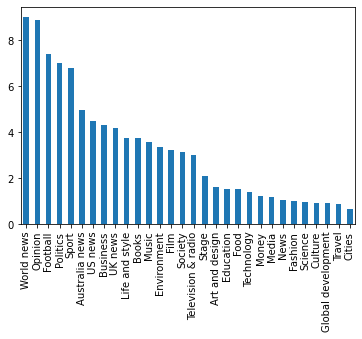

In [10]:
pillar_pc = category_percentage(df, 'sectionName')
print(pillar_pc)
pillar_pc.head(30).plot.bar()

News         49.36
Arts         18.64
Sport        14.32
Opinion       8.98
Lifestyle     8.71
Name: pillarName, dtype: float64


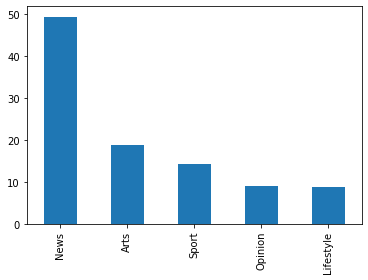

In [11]:
pillar_pc = category_percentage(df, 'pillarName')
print(pillar_pc)
pillar_pc.plot.bar()

News is the predominant pillar clearly.

(-100.0, 2000.0)

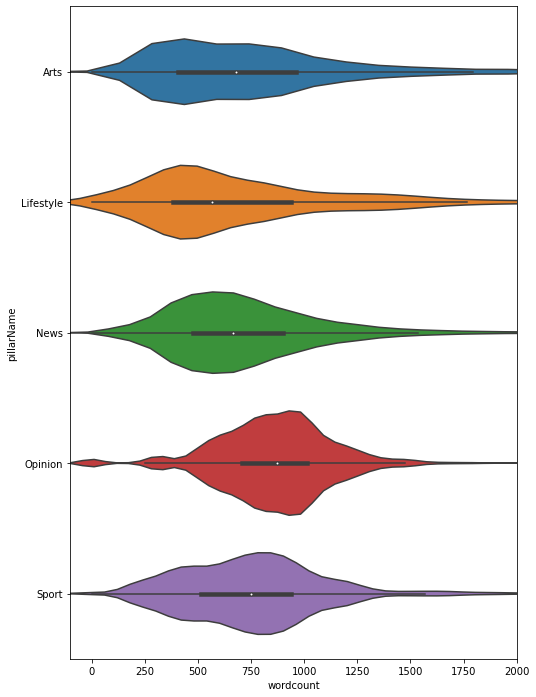

In [12]:
plt.figure(figsize = (8, 12))
sns.violinplot(y = 'pillarName', 
               x = 'wordcount', 
               data = df,
               orient='h')
plt.xlim(-100, 2000)

There is variation in the length of articles based on their pillars. 
- The opinion articles are most consistant in terms of article length and longest on average. 
- The distribution of opinion pieces is double peaked, with a smaller peak at approx 300 words. I assume these are editorial pieces.
- Sports and Arts pieces vary in length most substationally.
- Lifestyle content is generally the shortest in length.

<h2> Tokenizing by Sentence </h2>

    A brief exploration of sentence lengths wrt pillar types:

In [13]:
sent_tokenize(df.bodyText[5])  # Testing function with example

['For someone who professes to be into the new-fangled science of what makes people tick, I’m not sure it was the cleverest move to get into a rickety carriage on a fairground ferris wheel with a psychopathic killer.',
 'Still, the image of junior doctor Max Liebermann hanging from his fingertips over the city of Vienna after being hurled from the door, proved a thrilling, if completely avoidable – “hypnosis would be easier” – end to the first episode of Vienna Blood (BBC Two).',
 'It is set in Vienna in 1906, where gruff detective Oskar Rheinhardt (Juergen Maurer) is told that a young doctor – Liebermann (Matthew Beard), a fan of Freud – will be shadowing him to learn about “the psychopathy of the criminal mind”.',
 '“Catchy,” deadpans Rheinhardt.',
 'The three-part series will be compared, unavoidably, to Sherlock: its writer, Steve Thompson, adapting the Frank Tallis novels, was also a Sherlock scriptwriter.',
 'But Liebermann’s character study of his reluctant new mentor is so Holm

In [ ]:
sentence_tokens = df['bodyText'].apply(sent_tokenize)

In [ ]:
df['sentence_lengths'] = sentence_tokens.apply(lambda x: [len(tokens) for tokens in x])

In [ ]:
import functools
import operator

def sentence_histplot(pillar, colour):
    plt.hist(functools.reduce(operator.iconcat, 
                              df['sentence_lengths'][df['pillarName']==str(pillar)].values, []), 
             bins=range(0,401,5), 
             color = colour, 
             alpha=0.6, 
             label = pillar,
             histtype ='step',
            density=True,
            cumulative=True)
    

pillars = df.pillarName.unique()
colours = ['b', 'r', 'g', 'y', 'm', '0']
plt.figure(figsize=(12,6))
for i in range(len(pillars)):
    sentence_histplot(pillars[i], colours[i])
plt.legend()
plt.ylabel('Cumulative fraction', fontsize = 15)
plt.xlabel('Sentence Length (characters)', fontsize = 15)

There is some minimal relationship between sentence length and pillars:
- News articles tend to use longer sentences than the other pillars. 
- Lifestyle pieces use the shortest sentences. 
- The Sport, Arts and Opinion pieces are more or less the same as each other.

<h2> Cleaning for word tokenizing </h2>

In [ ]:
import string
from nltk.corpus import stopwords

In [ ]:
string.punctuation.split()

In [ ]:
stopwords
stopwords.words('english')[0:10] # Show some stop words

In [ ]:
# import re
# def text_process(originaltext):
#     """
#     Takes in a string of text, then performs the following:
#     1. Removes numbers and special characters (fortmatted punc etc)
#     2. Remove all standard punctuation
#     3. Remove all stopwords
#     4. Returns a list of the cleaned text
#     """
#     nonumsc = re.sub(r'\d+|\$|\£|\–|\’|\…|\”|\“', '', originaltext)
    
#     nopunc = [char for char in nonumsc if char not in string.punctuation]

#     nopunc = ''.join(nopunc)
    
#     return [word.lower() for word in nopunc.split() if word.lower() not in stopwords.words('english')]



In [ ]:
from nltk.stem import WordNetLemmatizer 
  
lemmatizer = WordNetLemmatizer() 

In [ ]:
text = df.bodyText[2285]

In [ ]:
def text_process(text):
    tokens = word_tokenize(text.lower())
    tokens = [contractions.fix(word) for word in tokens]
    tokens = [re.sub(r'\d+|\$|\£|\–|\’|\…|\”|\“', '', word) for word in tokens]
    tokens = [word for word in tokens if word not in string.punctuation]
    tokens = [word for word in tokens if word not in stopwords.words('english')]
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    tokens = [word for word in tokens if len(word) > 1]
    return tokens

In [ ]:
tok = text_process(text)
print(tok)

In [ ]:
text

<h2> NMF Model <h2>

In [ ]:
n_articles = 2000
df_train = df[:n_articles]

In [ ]:
df_train.info()

In [ ]:
texts = df_train.bodyText.apply(text_process)

In [ ]:
headlines = df_train.headline.values

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer = TfidfVectorizer(
    min_df=3,
    max_df=0.9,
    max_features=5000,
    ngram_range=(1, 2),
    preprocessor=' '.join
)

In [ ]:
tfidf = tfidf_vectorizer.fit_transform(texts)

In [ ]:
tfidf_fn = np.array(tfidf_vectorizer.get_feature_names())

In [ ]:
from sklearn.decomposition import NMF
nmf = NMF(n_components=25)

In [ ]:
from sklearn.preprocessing import Normalizer, MaxAbsScaler
from sklearn.pipeline import make_pipeline

scaler = MaxAbsScaler()
normalizer = Normalizer()

model = make_pipeline(scaler, nmf, normalizer)

In [ ]:
norm_features = model.fit_transform(tfidf)

In [ ]:
norm_features

In [ ]:
features = pd.DataFrame(norm_features, index=headlines)

In [ ]:
features.head()

<h3> Similarities </h3>
    
Selects other articles most similar in content according to the model. 

In [ ]:
article = features.iloc[460]
similarities = features.dot(article)
print(similarities.nlargest(10))

<h3> Topic Modelling </h3>

In [ ]:
for i, topic in enumerate(nmf.components_):
     print("\nTopic {}: {}".format(i + 1, ", ".join(
         [str(x) for x in tfidf_fn
          [topic.argsort()[:-15-1:-1]]])))

In [ ]:
def top_words(topic, n_top_words):
    return topic.argsort()[:-n_top_words - 1:-1]  

def topic_table(model, feature_names, n_top_words):
    topics = {}
    for topic_idx, topic in enumerate(model.components_):
        t = (topic_idx)
        topics[t] = [feature_names[i] for i in top_words(topic, n_top_words)]
    return pd.DataFrame(topics)

In [ ]:
topics_df = topic_table(nmf, tfidf_fn, 15).T

In [ ]:
topics_df['topics'] = topics_df.apply(lambda x: [', '.join(x)][0], axis=1) 

In [ ]:
topics_df = pd.DataFrame({'topic number': topics_df.index, 'topic':topics_df.topics})

In [ ]:
topics_df

In [ ]:
highest_topics = pd.DataFrame(norm_features.argmax(axis=1), columns=['topic number'])
print(highest_topics.info())

In [ ]:
highest_topics = highest_topics.merge(topics_df, on='topic number', how='left')
print(highest_topics.info())

In [ ]:
df_headline = pd.DataFrame(headlines, columns=['headline'])
print(df_headline.info())
info_df = df_train[['sectionName', 'pillarName', 'headline']]
print(info_df.info())

In [ ]:
df_article_topic = df_headline.join(highest_topics)
print(df_article_topic.info())

df_article_topic = df_article_topic.merge(info_df, on='headline', how='inner')
print(df_article_topic.info())

In [ ]:
df_article_topic

In [ ]:
df_train.headline.nunique()